In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('Stocks Dataset/TSLA.csv')

In [2]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.iloc[2395]

Date         2020-01-03
Open          29.366667
High          30.266666
Low              29.128
Close            29.534
Adj Close        29.534
Volume        266677500
Name: 2395, dtype: object

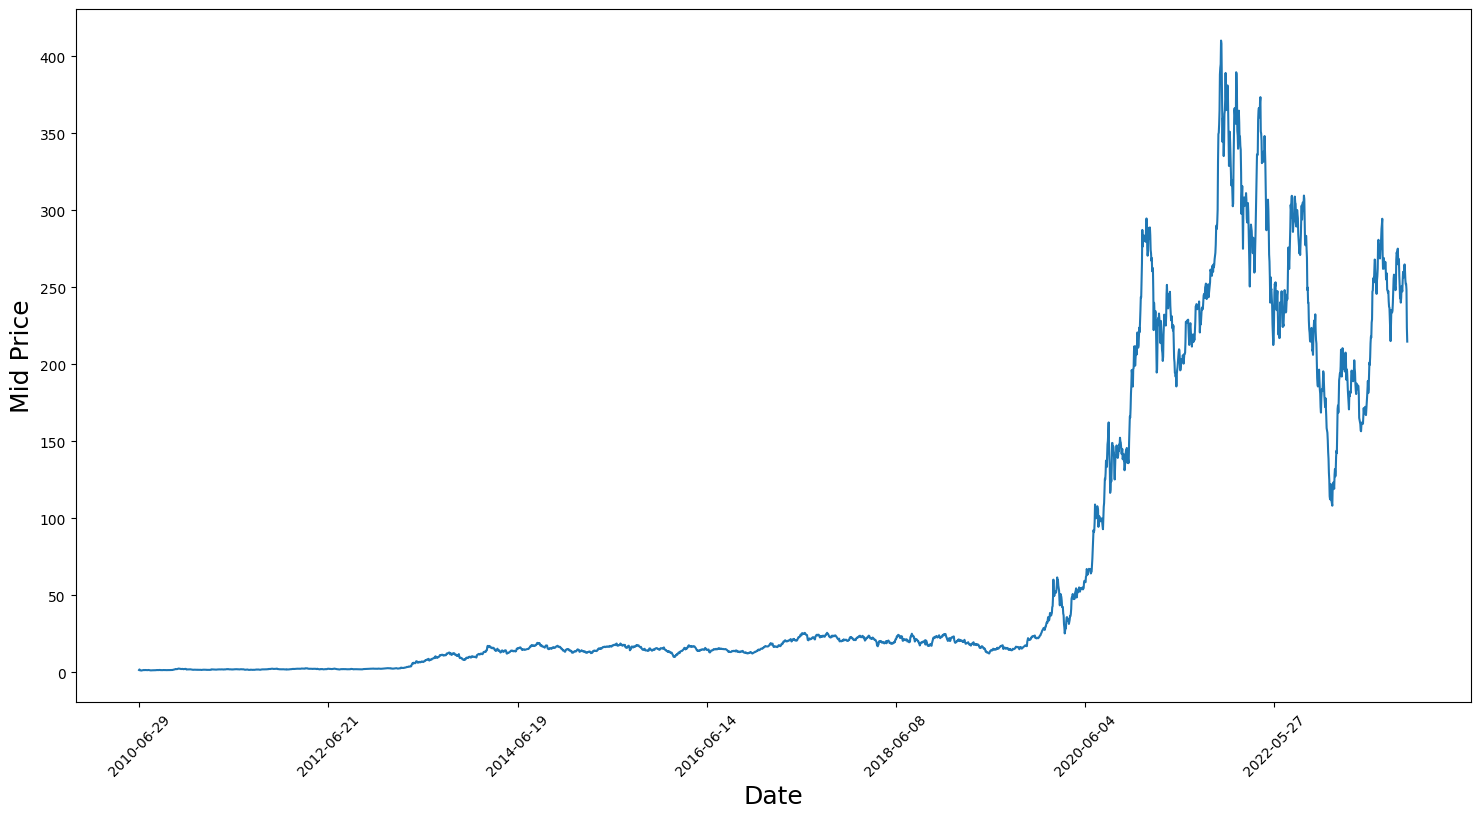

In [3]:
#Data Visualization
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [4]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

print(len(mid_prices))

3352


In [5]:
#first 11000
train_data = mid_prices[:2395]
test_data = mid_prices[2395:]

In [6]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

train_data

array([[ 1.418    ],
       [ 1.7906665],
       [ 1.5396665],
       ...,
       [27.942    ],
       [27.445666 ],
       [28.4136665]])

In [7]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 238
for di in range(0,1390,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])


In [8]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [9]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(2395):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [10]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.compat.v1.reset_default_graph() # This is important in case you run this multiple times

In [11]:
# Input data.
train_inputs, train_outputs = [],[]

#disable eager execution
tf.compat.v1.disable_eager_execution()

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


In [13]:
lstm_cells = [
    tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform")
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.compat.v1.nn.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_cells)

w = tf.compat.v1.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
b = tf.compat.v1.get_variable('b',initializer=tf.random.uniform([1],-0.1,0.1))


C:\Users\ACER\AppData\Local\Temp\ipykernel_30572\3297879699.py:2: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=num_nodes[li],


AttributeError: module 'tensorflow.compat.v1.nn' has no attribute 'rnn'

In [ ]:
#When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.compat.v1.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.compat.v1.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.compat.v1.assign(global_step,global_step + 1)
tf_learning_rate = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.compat.v1.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

In [ ]:
print('Defining prediction related TF functions')

sample_inputs = tf.compat.v1.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.nn.rnn_cell.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.compat.v1.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.compat.v1.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.compat.v1.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.compat.v1.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.compat.v1.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):
  sample_prediction = tf.compat.v1.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')